In [1]:
import os
import time
import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Generate model that returns the prediction

Note that while training the model, I have only trained it on the dataset provided without applying any data augmentation techniques. Training accuracy obtained was ~63%

In [428]:
# helper method to define model
def deepnn(x):
    x_image = tf.reshape(x, [-1, 32, 32, 3])
    
    # Conv Layer 1
    W_conv1 = tf.get_variable("weight_1", shape=[5, 5, 3, 6], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv1 = tf.get_variable("bias_1", shape=[6], initializer=tf.constant_initializer(0.1))
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Max Pooling Layer 1
    h_pool1 = max_pool_2x2(h_conv1)

    # Conv Layer 2
    W_conv2 = tf.get_variable("weight_2", shape=[5, 5, 6, 16], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_conv2 = tf.get_variable("bias_2", shape=[16], initializer=tf.constant_initializer(0.1))
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # Max Pooling Layer 2
    h_pool2 = max_pool_2x2(h_conv2)

    h_pool_flatten = tf.reshape(h_pool2, (-1, 8*8*16))

    # Fully Connected 1
    W_fc1 = tf.get_variable("weight_3", shape=[8*8*16, 120], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_fc1 = tf.get_variable("bias_3", shape=[120], initializer=tf.constant_initializer(0.1))
    h_fc1 = tf.matmul(h_pool_flatten, W_fc1) + b_fc1
    
    # Fully connected 2
    W_fc2 = tf.get_variable("weight_4", shape=[120, 10], initializer=tf.truncated_normal_initializer(stddev=0.1))
    b_fc2 = tf.get_variable("bias_4", shape=[10],initializer=tf.constant_initializer(0.1))
    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    return y_conv

# Helper functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape, i):
    return tf.get_variable("weight", shape=shape, initializer=tf.truncated_normal_initializer(stddev=0.1))


def bias_variable(shape, i):
    return tf.get_variable("bias", shape=shape, initializer=tf.constant_initializer(0.1))

In [429]:
# create Dummy class 
class Dummy():
    pass

env = Dummy()

In [4]:
def fgmt(model, x, y=None, eps=0.01, epochs=1, sign=True, clip_min=0.,
         clip_max=1.):
    """
    Fast gradient method with target
    See https://arxiv.org/pdf/1607.02533.pdf.  This method is different from
    FGM that instead of decreasing the probability for the correct label, it
    increases the probability for the desired label.
    :param model: A model that returns the output as well as logits.
    :param x: The input placeholder.
    :param y: The desired target label, set to the least-likely class if None.
    :param eps: The noise scale factor.
    :param epochs: Maximum epoch to run.
    :param sign: Use gradient sign if True, otherwise gradient values.
    :param clip_min: Minimum value in output.
    :param clip_max: Maximum value in output.
    """
    xadv = tf.identity(x)

    ybar = model(xadv)
    ydim = ybar.get_shape().as_list()[1]
    n = tf.shape(ybar)[0]

    if y is None:
        indices = tf.argmin(ybar, axis=1)
    else:
        indices = tf.cond(tf.equal(0, tf.rank(y)),
                          lambda: tf.zeros([n], dtype=tf.int32) + y,
                          lambda: tf.zeros([n], dtype=tf.int32))

    target = tf.cond(
        tf.equal(ydim, 1),
        lambda: 1 - ybar,
        lambda: tf.one_hot(indices, ydim, on_value=1.0, off_value=0.0))

    if 1 == ydim:
        loss_fn = tf.nn.sigmoid_cross_entropy_with_logits
    else:
        loss_fn = tf.nn.softmax_cross_entropy_with_logits

    if sign:
        noise_fn = tf.sign
    else:
        noise_fn = tf.identity

    eps = -tf.abs(eps)

    def _cond(xadv, i):
        return tf.less(i, epochs)

    def _body(xadv, i):
        ybar = model(xadv)
        loss = loss_fn(labels=target, logits=ybar)
        dy_dx, = tf.gradients(loss, xadv)
        xadv = tf.stop_gradient(xadv + eps*noise_fn(dy_dx))
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)
        return xadv, i+1

    xadv, _ = tf.while_loop(_cond, _body, (xadv, 0), back_prop=False,
                            name='fast_gradient_target')
    return xadv

In [5]:
# defining environment in which the model is set

with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, 32, 32, 3),
                           name='x')
    env.y = tf.placeholder(tf.float32, (None, 10), name='y')
    env.ybar = deepnn(env.x)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=env.ybar)
        env.loss = tf.reduce_mean(xent, name='loss')

    optimizer = tf.train.AdamOptimizer()
    env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.train.Saver(tf.global_variables()[:8])

with tf.variable_scope('model', reuse=True):
    env.adv_eps = tf.placeholder(tf.float32, (), name='adv_eps')
    env.adv_epochs = tf.placeholder(tf.int32, (), name='adv_epochs')
    env.adv_y = tf.placeholder(tf.int32, (), name='adv_y')
    env.x_fgmt = fgmt(deepnn, env.x, y=env.adv_y, epochs=env.adv_epochs,
                      eps=env.adv_eps)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [6]:
sess = tf.InteractiveSession()

In [8]:
# Load trained model

env.saver.restore(sess, '/home/lenovo/Documents/IITB/code/Visualising_Convolutional_Networks/cifar_model/model_chkpt-8870')

INFO:tensorflow:Restoring parameters from /home/lenovo/Documents/IITB/code/Visualising_Convolutional_Networks/cifar_model/model_chkpt-8870


In [34]:
def make_fgmt(sess, env, X_data, target_class, epochs=1, eps=0.01, batch_size=128):
    """
    Generate FGSM by running env.x_fgsm.
    """
    print('\nMaking adversarials via FGSM')

    X_adv = np.empty_like(X_data)

    adv = sess.run(env.x_fgmt, feed_dict={
        env.x: X_data,
        env.adv_y: target_class,
        env.adv_eps: eps,
        env.adv_epochs: epochs})
    X_adv[0] = adv
    print('Done')

    return X_adv

In [15]:
def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    y_batch = sess.run(env.ybar, feed_dict={env.x: X_data})
    yval = y_batch
    print()
    return yval

##### The following three cells are an alternate way to load the data 

In [11]:
# filename = './cifar/tfrecords/eval.tfrecords/'
# record_iterator = tf.python_io.tf_record_iterator(filename)
# serialized_img_example = next(record_iterator)

In [86]:
# serialized_img_example = next(record_iterator)

In [87]:
# example = tf.train.Example()
# example.ParseFromString(serialized_img_example)
# image = example.features.feature['image'].bytes_list.value
# label = example.features.feature['label'].int64_list.value[0]

### Loading data from pickle file directly

In [118]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as f:
        dict = cPickle.load(f)
        
    return dict

In [423]:
dirname = './cifar/cifar-10-batches-py'
filename = 'test_batch'

file = os.path.join(dirname, filename)

data_dict = unpickle(file)

img = data_dict['data'][1]
lbl = data_dict['labels'][1]

In [424]:
import matplotlib.pyplot as plt
% matplotlib inline

In [425]:
red = img[0:1024].reshape(32, 32)
green = img[1024:2048].reshape(32, 32)
blue = img[2048:].reshape(32, 32)
new_img = np.dstack((red, green, blue))

In [426]:
original_image = new_img

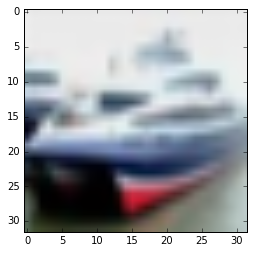

In [427]:
plt.imshow(new_img)
plt.savefig('./cifar_adv/actual_8.png')

In [362]:
new_img = new_img.astype(np.float32)

In [363]:
img_flat = img.astype(np.float32)
label = np.float32(lbl)

In [364]:
lbl

8

In [365]:
sess2 = tf.InteractiveSession()
'''This computes (x - mean) / adjusted_std_dev
mean is the mean of pixel intensities in the image
adjusted_std_dev = max(stddev, 1.0 / sqrt(image.NumElements()))
stddev is the std dev of the values in the image
''' 
img = sess2.run(tf.image.per_image_standardization(new_img))

In [366]:
# Adding an extra dimension

img = np.expand_dims(img, axis=0)

In [367]:
img.shape

(1, 32, 32, 3)

In [368]:
# Predicting output on original image

op = predict(sess, env, img)


Predicting
()


In [369]:
print(op)
np.argmax(op, axis=1)

[[ 3.5810885   3.8944073  -0.45889214 -1.541553   -1.8760597  -3.4214509
  -2.8574212  -3.0080667   4.9980044   2.6712909 ]]


array([8])

In [416]:
# Generating adversarial image

X_adv = make_fgmt(sess, env, img, 1, eps=0.01, epochs=4)


Making adversarials via FGSM
Done


In [417]:
# Getting output prediction on the adversarial image

adv_op = predict(sess, env, X_adv)


Predicting
()


In [418]:
print(adv_op)
np.argmax(adv_op)

[[ 0.72425056  1.7130115   0.29495713 -0.2910619  -1.5871686  -0.86292434
   0.38960022 -2.1117704   1.1292125  -0.61637354]]


1

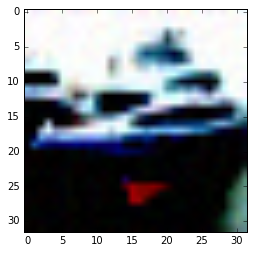

In [421]:
plt.imshow(X_adv.reshape(32, 32, 3))
plt.savefig('./cifar_adv/actual_8_adv_1.png')